In [2]:
import numpy as np
import pandas as pd

from datetime import datetime as dt

In [3]:
pd.set_option('display.max_columns', 500)

In [46]:
raw_df = pd.read_csv("brand_new_sample.csv", index_col=0, parse_dates=['offer_dt'])
raw_df.shape

(9296, 39)

In [47]:
raw_df.drop_duplicates(inplace=True)

In [48]:
raw_df['Общая'] = raw_df['Общая'].apply(lambda x: float(x.split()[0].replace(',', '.')) if isinstance(x, str) else x)

In [49]:
USD = 75.0

raw_df[raw_df['price_currency'] == 'USD']['price'] = raw_df['price'] * USD 

In [50]:
raw_df.drop(raw_df[raw_df['agent_warning'] == True].index, inplace=True)
raw_df.drop('agent_warning', axis=1, inplace=True)

In [51]:
raw_df.drop(columns=['price_currency',
    'Строительная серия',
                     'Лифты',
                     'Отопление',
                     'Аварийность',
                     'Тип перекрытий',
                     'Мусоропровод',
                     'Подъезды',
                     'Отделка',
                     'Сдан',
                     'Ремонт',
                    'Площадь комнат',
                    'Кухня',
                    'Газоснабжение',
                    'Срок сдачи',
                    'Планировка',
                    'Тип дома'], inplace=True)

In [52]:
raw_df['Высота потолков'] = pd.to_numeric(raw_df['Высота потолков'].str.replace('м', '').str.strip().str.replace(',', '.'))
raw_df['Высота потолков'].fillna(raw_df['Высота потолков'].median(), inplace=True)

In [53]:
raw_df.dropna(subset=['price'], inplace=True)
raw_df['Всего этажей'] = raw_df['Этаж'].apply(lambda x: x.replace('из', '').split()[1])
raw_df['Этаж'] = raw_df['Этаж'].apply(lambda x: x.replace('из', '').split()[0])

In [54]:
raw_df['Апартаменты'] = raw_df['Тип жилья'].apply(lambda x: 'апартамент' in x.lower())
raw_df['Новостройка'] = raw_df['Тип жилья'].apply(lambda x: 'новостройка' in x.lower())
raw_df.drop('Тип жилья', axis=1, inplace=True)

In [55]:
raw_df['Вид из окон'].fillna('', inplace=True)
raw_df['Окна во двор'] = raw_df['Вид из окон'].apply(lambda x: 'двор' in x.lower())
raw_df['Окна на улицу'] = raw_df['Вид из окон'].apply(lambda x: 'улиц' in x.lower())
raw_df.drop('Вид из окон', axis=1, inplace=True)

In [57]:
raw_df['district'] = raw_df['address'].apply(lambda x: x.split(',')[1])

In [58]:
def extract_room_number(x):
    if 'свобод' in x.lower() or 'студия' in x.lower():
        return 'студия'
    else:
        return x.split('-')[0]
    
raw_df['количество комнат'] = raw_df['title'].apply(lambda x: extract_room_number(x))
raw_df.drop('title', axis=1, inplace=True)

In [59]:
raw_df['Санузел'].fillna(raw_df['Санузел'].value_counts().index[0], inplace=True)
raw_df['Количество санузлов'] = raw_df['Санузел'].apply(lambda x: x.split()[0])
raw_df['Совмещенный санузел'] = raw_df['Санузел'].apply(lambda x: 'совмещен' in x.lower())
raw_df.drop(columns=['Санузел'], inplace=True)

In [60]:
raw_df['Парковка'].fillna('', inplace=True)
raw_df['Парковка'] = raw_df['Парковка'].apply(lambda x: 'наземная' if 'открыт' in x.lower() or not x else x.lower())

In [61]:
raw_df['Балкон/лоджия'].fillna('', inplace=True)
raw_df['балкон'] = raw_df['Балкон/лоджия'].apply(lambda x: sum(map(lambda x: int(x) if x.isdigit() else 0, x.split())))
raw_df.drop(columns=['Балкон/лоджия'], inplace=True)

In [62]:
raw_df.loc[raw_df['Построен'].isna(), 'Построен'] = raw_df['Год постройки'][raw_df['Построен'].isna()]
raw_df['Построен'].ffill(inplace=True)
raw_df.drop('Год постройки', axis=1, inplace=True)

In [63]:
def extract_time_to_undeground(x):
    if not x:
        return -1
    time_to = int(x.split()[0])
    if 'транспорт' in x:
        time_to = time_to * 5
    return time_to


In [64]:
def extract_living_square(x):
    if not x: 
        return 0.0
    value = float(x.split()[0].replace(',', '.'))
    return value

living_square_mask = raw_df['Жилая'].notna()
raw_df['living_square_ratio'] = 0.0
raw_df.loc[living_square_mask, 'living_square_ratio'] = (
     pd.to_numeric(
        raw_df['Жилая'][living_square_mask].apply(lambda x: extract_living_square(x))) / raw_df['Общая'][living_square_mask]
)
raw_df.loc[raw_df['living_square_ratio'] == 0.0, 'living_square_ratio'] = raw_df['living_square_ratio'].median()
raw_df.drop('Жилая', axis=1, inplace=True)

In [65]:
today = dt.today()
raw_df['placed_days_ago'] = raw_df['offer_dt'].apply(lambda x: (today - x).round(freq='D').days)

In [66]:
raw_df.drop('distance_to_mkad', axis=1, inplace=True)

In [67]:
raw_df.drop(raw_df[raw_df['time_to_underground'].isna() == True].index, inplace=True)

In [68]:
raw_df.drop_duplicates(inplace=True)

                 3120
Косметический    2337
Евроремонт       1015
Без ремонта       989
Дизайнерский      239
Name: Ремонт, dtype: int64

In [28]:
raw_df.to_csv('prepared_data.csv')

In [37]:
raw_df.rename(columns={"Общая": "general_sq",
               "Этаж": "floor",
               "Построен": "built",
               "Высота потолков": "ceil",
              "Всего этажей": "total_floors",
              "Апартаменты": "apartments",
              "Новостройка": "new_building",
              "Окна во двор": "courtyard_view",
               "Окна на улицу": "road_view",
              "количество комнат": "rooms",
               "Количество санузлов": "wc_amount",
               "Совмещенный санузел": "joint_wc",
               "балкон": "balcony",
                       'Парковка': 'parking',
              }, inplace=True)

In [38]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7741 entries, 0 to 9294
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   link                 7741 non-null   object        
 1   price                7741 non-null   float64       
 2   description_len      7741 non-null   float64       
 3   general_sq           7741 non-null   float64       
 4   floor                7741 non-null   int64         
 5   built                7741 non-null   float64       
 6   ceil                 7741 non-null   float64       
 7   facing               7741 non-null   object        
 8   parking              7741 non-null   object        
 9   time_to_underground  7741 non-null   float64       
 10  address              7741 non-null   object        
 11  offer_dt             7741 non-null   datetime64[ns]
 12  all_views            7741 non-null   float64       
 13  today_views          7741 non-nul

In [60]:
raw_df.describe()

,price,description_len,general_sq,floor,built,ceil,time_to_underground,all_views,today_views,total_floors,wc_amount,balcony,living_square_ratio,placed_days_ago
count,7.738000e+03,7738.000000,7738.000000,7738.000000,7738.000000,7738.000000,7738.000000,7738.000000,7738.000000,7738.000000,7738.000000,7738.000000,7738.000000,7738.000000
mean,7.758320e+06,845.024683,34.432903,6.976092,1990.923494,2.733886,27.704058,899.072499,13.964073,14.495735,1.013311,0.453089,0.526333,6.544973
std,1.351260e+06,621.833505,9.770197,5.588173,23.105914,0.188518,33.592138,2301.776326,30.091447,7.249165,0.114610,0.528553,0.116387,6.325484
min,2.280000e+06,24.000000,9.700000,1.000000,1856.000000,2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.205128,3.000000
25%,7.009882e+06,412.000000,28.547500,2.000000,1971.000000,2.650000,10.000000,102.000000,1.000000,9.000000,1.000000,0.000000,0.474748,3.000000
50%,8.190000e+06,661.000000,35.000000,5.000000,1988.000000,2.700000,15.000000,342.000000,4.000000,14.000000,1.000000,0.000000,0.500000,4.000000
75%,8.800000e+06,1106.000000,39.000000,10.000000,2015.000000,2.720000,30.000000,947.750000,15.000000,17.000000,1.000000,1.000000,0.590909,6.000000
max,9.400000e+06,3000.000000,130.000000,45.000000,2021.000000,5.400000,400.000000,95969.000000,1116.000000,54.000000,2.000000,4.000000,1.000000,37.000000


In [42]:
raw_df['floor'] = pd.to_numeric(raw_df['floor'])
raw_df['total_floors'] = pd.to_numeric(raw_df['total_floors'])
raw_df['wc_amount'] = pd.to_numeric(raw_df['wc_amount'])
raw_df['balcony'] = pd.to_numeric(raw_df['balcony'])

In [47]:
raw_df.loc[raw_df['ceil'] > 20.0, 'ceil'] = raw_df['ceil'][raw_df['ceil'] > 20.0] / 10

In [54]:
raw_df.drop(raw_df[raw_df['ceil'] > 7.0].index, inplace=True)

In [59]:
raw_df.drop(raw_df[raw_df['general_sq'] == 2.0].index, inplace=True)

In [ ]:
# data preparing ends here

Original shape: (9296, 39)
Shape without duplicates: (9008, 39)
Shape without nan prices: (8839, 39)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7697 entries, 0 to 9294
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   link                 7697 non-null   object        
 1   price                7697 non-null   float64       
 2   description_len      7697 non-null   float64       
 3   general_sq           7697 non-null   float64       
 4   floor                7697 non-null   int64         
 5   built                7697 non-null   float64       
 6   ceil                 7697 non-null   float64       
 7   Ремонт               4579 non-null   object        
 8   parking              7697 non-null   object        
 9   time_to_underground  7697 non-null   float64       
 10  address              7697 non-null   object        
 11  offer_dt             7697 non-null   datetime6

In [ ]:
import matplotlib.pyplot as plt

In [70]:
corr = raw_df.corr()
corr.style.background_gradient()

,price,description_len,general_sq,floor,built,ceil,time_to_underground,all_views,today_views,total_floors,apartments,new_building,courtyard_view,road_view,wc_amount,joint_wc,balcony,living_square_ratio,placed_days_ago
price,1.000000,-0.152461,0.554786,0.110728,-0.124372,-0.175832,-0.145846,-0.139285,-0.290477,0.134315,-0.343296,-0.074122,0.105454,0.018495,0.055396,-0.169581,0.179034,-0.154432,0.045961
description_len,-0.152461,1.000000,0.056754,0.086821,0.144301,0.085305,0.132119,-0.095970,-0.107372,0.141578,0.067662,0.459338,-0.211263,0.028657,0.078094,0.142201,-0.148496,-0.129594,-0.202944
general_sq,0.554786,0.056754,1.000000,-0.049424,0.006668,-0.117751,0.313936,-0.043099,-0.100933,-0.082294,-0.294150,-0.001733,0.018865,0.028093,0.227089,-0.262906,0.291031,-0.161958,0.035230
floor,0.110728,0.086821,-0.049424,1.000000,0.203904,-0.023937,-0.073480,-0.103723,-0.115453,0.510986,-0.073634,0.246195,-0.082158,0.039776,-0.034214,0.112028,0.030492,-0.173065,-0.040251
built,-0.124372,0.144301,0.006668,0.203904,1.000000,0.138900,0.089103,-0.066466,-0.065452,0.293395,0.097669,0.134309,-0.120309,0.061631,0.028205,0.099481,0.002341,-0.179972,-0.060178
ceil,-0.175832,0.085305,-0.117751,-0.023937,0.138900,1.000000,-0.009106,0.017374,0.085393,-0.022436,0.274066,0.096334,-0.055688,0.029870,0.054854,0.097551,-0.125011,-0.032591,-0.084707
time_to_underground,-0.145846,0.132119,0.313936,-0.073480,0.089103,-0.009106,1.000000,-0.051466,-0.054208,-0.149322,-0.164910,0.032002,-0.070771,-0.005392,0.089551,-0.075167,0.166828,-0.041864,-0.032263
all_views,-0.139285,-0.095970,-0.043099,-0.103723,-0.066466,0.017374,-0.051466,1.000000,0.311334,-0.144684,0.152248,-0.169715,0.049624,0.022724,-0.004333,-0.052984,-0.013411,0.135549,0.140218
today_views,-0.290477,-0.107372,-0.100933,-0.115453,-0.065452,0.085393,-0.054208,0.311334,1.000000,-0.174526,0.149130,-0.217833,0.057025,0.001849,-0.011404,-0.036684,-0.011979,0.145298,0.008458
total_floors,0.134315,0.141578,-0.082294,0.510986,0.293395,-0.022436,-0.149322,-0.144684,-0.174526,1.000000,-0.076929,0.422079,-0.150087,0.005218,-0.043879,0.128265,-0.127140,-0.272771,-0.090272


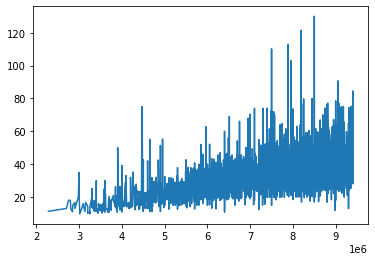

In [73]:
plt.plot(raw_df['price'], raw_df['general_sq'])

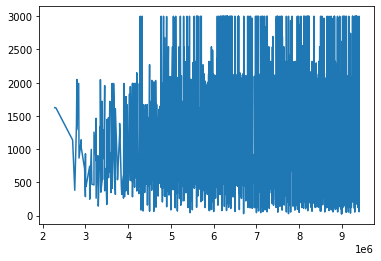

In [74]:
plt.plot(raw_df['price'], raw_df['description_len'])

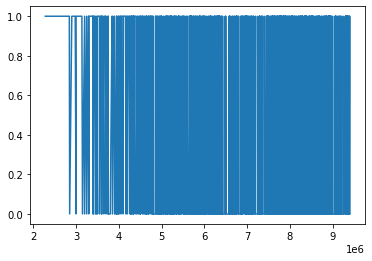

In [75]:
plt.plot(raw_df['price'], raw_df['apartments'])

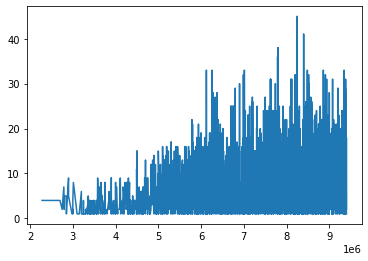

In [76]:
plt.plot(raw_df['price'], raw_df['floor'])

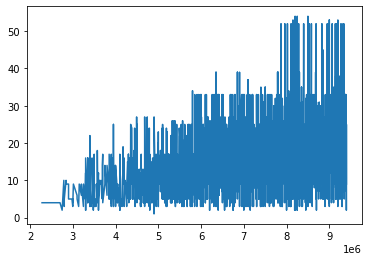

In [77]:
plt.plot(raw_df['price'], raw_df['total_floors'])

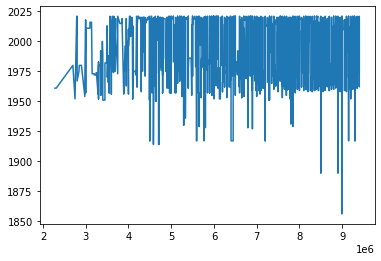

In [78]:
plt.plot(raw_df['price'], raw_df['built'])

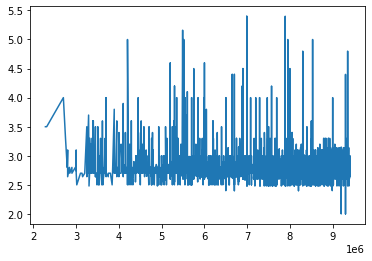

In [80]:
plt.plot(raw_df['price'], raw_df['ceil'])

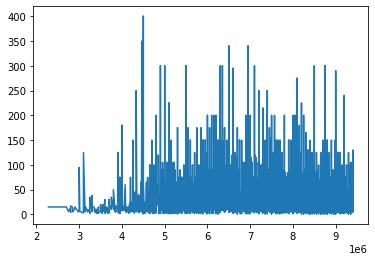

In [81]:
plt.plot(raw_df['price'], raw_df['time_to_underground'])

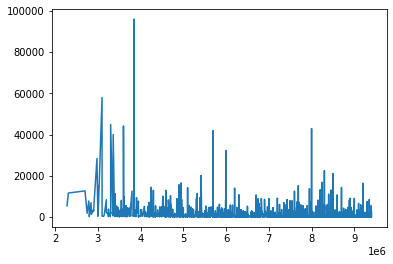

In [85]:
plt.plot(raw_df['price'], raw_df['all_views'])

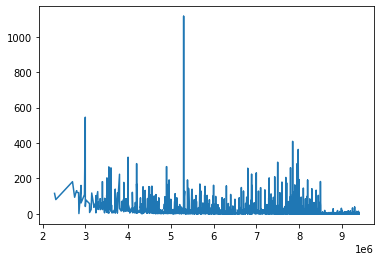

In [86]:
plt.plot(raw_df['price'], raw_df['today_views'])

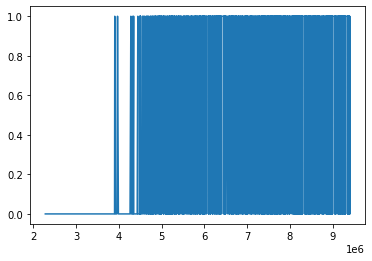

In [87]:
plt.plot(raw_df['price'], raw_df['new_building'])

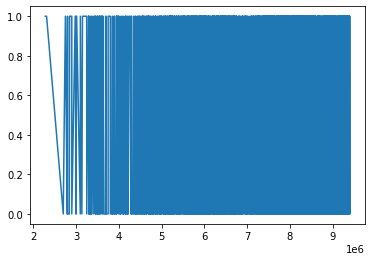

In [89]:
plt.plot(raw_df['price'], raw_df['courtyard_view'])

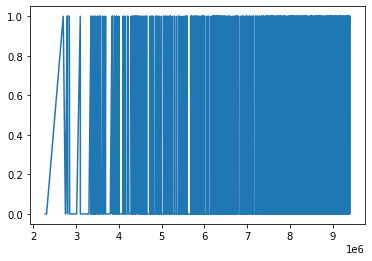

In [90]:
plt.plot(raw_df['price'], raw_df['road_view'])

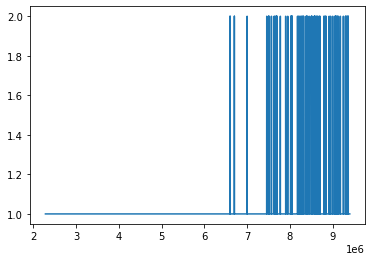

In [91]:
plt.plot(raw_df['price'], raw_df['wc_amount'])

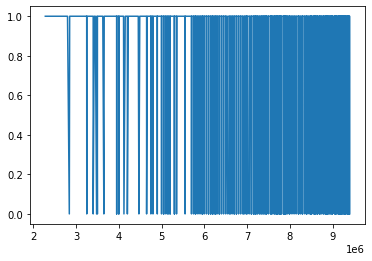

In [92]:
plt.plot(raw_df['price'], raw_df['joint_wc'])

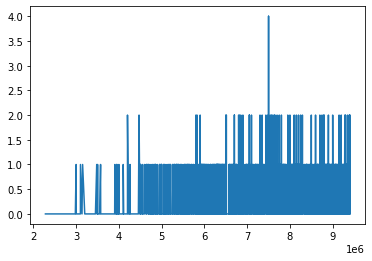

In [93]:
plt.plot(raw_df['price'], raw_df['balcony'])

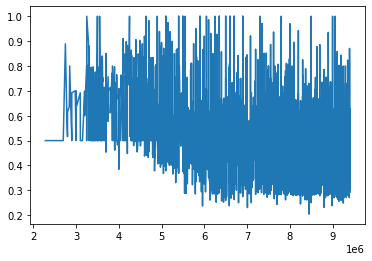

In [95]:
plt.plot(raw_df['price'], raw_df['living_square_ratio'])

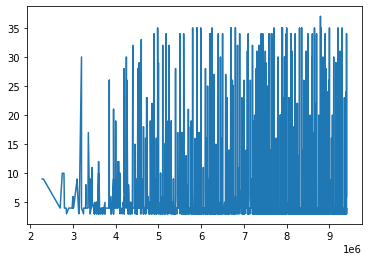

In [96]:
plt.plot(raw_df['price'], raw_df['placed_days_ago'])

In [99]:
import seaborn as sns

In [74]:
plt.figure(figsize=(25, 6))
bar_plot = sns.barplot(data=raw_df, x="built", y="price")
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=90);

NameError: name 'plt' is not defined

<AxesSubplot:xlabel='built', ylabel='general_sq'>

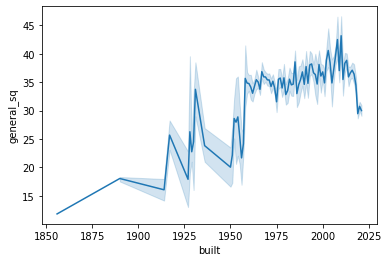

In [105]:
sns.lineplot(data=raw_df, x="built", y="general_sq")

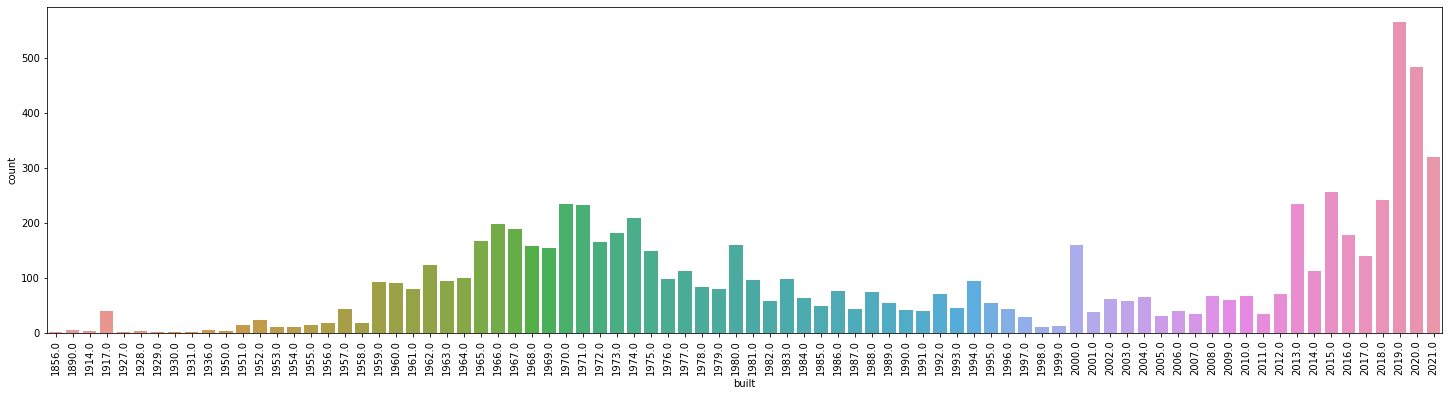

In [109]:
plt.figure(figsize=(25, 6))
built_cnt_plt = sns.countplot(data=raw_df, x="built")
built_cnt_plt.set_xticklabels(built_cnt_plt.get_xticklabels(), rotation=90);

In [114]:
rounded = raw_df['general_sq'].round()


pandas.core.series.Series

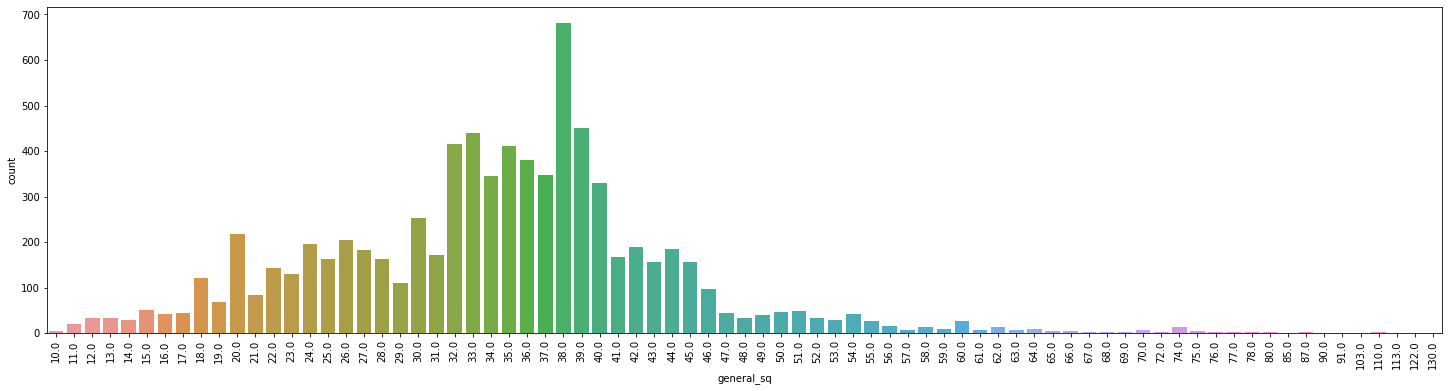

In [117]:
plt.figure(figsize=(25, 6))
general_sq_cnt_plt = sns.countplot(x=rounded)
general_sq_cnt_plt.set_xticklabels(general_sq_cnt_plt.get_xticklabels(), rotation=90);

In [1]:
import seaborn as sns